In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
from scipy.spatial.transform import Rotation as R

glasses_to_ear = 0.06
glasses_to_back = 0.11

eyeball = np.array([0.0, 0.0, glasses_to_ear])
line_tip = np.array([0.0, 0.0, 1.0])


def get_gaze_in_head(gaze_df, head_df, head_idx):
    gaze_idxs = (gaze_df["timestamp [s]"] > df["start_timestamp"][head_idx]) & (
        gaze_df["timestamp [s]"] < df["end_timestamp"][head_idx]
    )

    elv = np.mean(gaze_df[gaze_idxs]["elevation [deg]"])
    azi = np.mean(gaze_df[gaze_idxs]["azimuth [deg]"])
    eye_ele_azi = np.array([-1.0 * elv, azi])
    eye_rot = R.from_euler("XY", eye_ele_azi, degrees=True)

    head_quat = np.array(
        [
            head_df.iloc[head_idx]["rotation_x"],
            head_df.iloc[head_idx]["rotation_y"],
            head_df.iloc[head_idx]["rotation_z"],
            head_df.iloc[head_idx]["rotation_w"],
        ]
    )
    head_rot = R.from_quat(head_quat)

    eye_in_head = head_rot.apply(eyeball)

    head_vec = head_rot.apply(line_tip)
    gaze_vec = eye_rot.apply(head_vec)

    return eye_in_head, gaze_vec, head_vec


In [12]:
df = pd.read_csv("./recordings/2024-04-12_185528/aligned_poses.csv")

In [14]:
import json

info = []
with open("./recordings/2024-04-12_185528/info.json") as f:
    info = json.load(f)

start_ts = info["start_time"]

gaze_df = pd.read_csv("./recordings/2024-04-12_185528/gaze.csv")
gaze_df["timestamp [s]"] = (gaze_df["timestamp [ns]"] - start_ts) * 1e-9
gaze_df.head()

,section id,recording id,timestamp [ns],gaze x [px],gaze y [px],worn,fixation id,blink id,azimuth [deg],elevation [deg],timestamp [s]
0,d4a45692-1602-4b97-a12c-b4ae0c889d0c,d1e2a8c5-223b-4fb0-afdc-d680af222a27,1712940932101149584,698.909,876.948,1.0,1.0,NaN,-8.327326,-17.027001,3.44015
1,d4a45692-1602-4b97-a12c-b4ae0c889d0c,d1e2a8c5-223b-4fb0-afdc-d680af222a27,1712940932106149584,694.928,875.671,1.0,1.0,NaN,-8.589403,-16.940941,3.44515
2,d4a45692-1602-4b97-a12c-b4ae0c889d0c,d1e2a8c5-223b-4fb0-afdc-d680af222a27,1712940932111149584,700.893,877.961,1.0,1.0,NaN,-8.197303,-17.094073,3.45015
3,d4a45692-1602-4b97-a12c-b4ae0c889d0c,d1e2a8c5-223b-4fb0-afdc-d680af222a27,1712940932116149584,701.096,877.250,1.0,1.0,NaN,-8.182515,-17.048676,3.45515
4,d4a45692-1602-4b97-a12c-b4ae0c889d0c,d1e2a8c5-223b-4fb0-afdc-d680af222a27,1712940932121149584,705.854,876.799,1.0,1.0,NaN,-7.865626,-17.024571,3.46015


/var/folders/by/f4g6q8690z50zbfvy6kq71cc0000gn/T/ipykernel_99419/87086643.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(


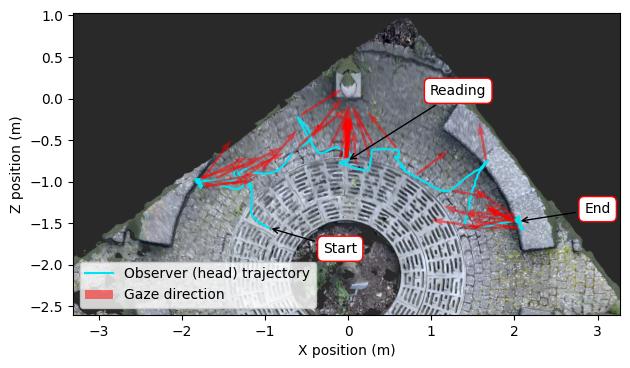

In [15]:
import matplotlib.animation as animation

plt.plot(
    df["translation_x"],
    df["translation_z"],
    "b-",
    color=(0.002, 0.886, 0.955),
    zorder=1,
    label="Observer (head) trajectory",
)

plt.xlim(-3.31, 3.27)
plt.ylim(-2.60, 1.03)

img = plt.imread("./overhead.png")
imgp = plt.imshow(img, extent=[-3.31, 3.27, -2.60, 1.03], zorder=0)

plt.xlabel("X position (m)")
plt.ylabel("Z position (m)")

plt.annotate(
    "Start",
    xy=(df["translation_x"][0], df["translation_z"][0]),
    xytext=(-0.3, df["translation_z"][0] - 0.3),
    arrowprops=dict(color="black", arrowstyle="->"),
    backgroundcolor="white",
    color="black",
    bbox=dict(facecolor="white", edgecolor="red", boxstyle="round,pad=0.4"),
)

plt.annotate(
    "Reading",
    xy=(df["translation_x"][720], df["translation_z"][720]),
    xytext=(
        df["translation_x"][720] + 1.0,
        df["translation_z"][720] + 0.8,
    ),
    arrowprops=dict(color="black", arrowstyle="->"),
    backgroundcolor="white",
    color="black",
    bbox=dict(facecolor="white", edgecolor="red", boxstyle="round,pad=0.4"),
)

plt.annotate(
    "End",
    xy=(df["translation_x"][len(df) - 1], df["translation_z"][len(df) - 1]),
    xytext=(
        df["translation_x"][len(df) - 1] + 0.8,
        df["translation_z"][len(df) - 1] + 0.1,
    ),
    arrowprops=dict(color="black", arrowstyle="->"),
    backgroundcolor="white",
    color="black",
    bbox=dict(facecolor="white", edgecolor="red", boxstyle="round,pad=0.4"),
)


for frame in range(0, len(df), 32):
    eye_in_head, gaze_vec, head_vec = get_gaze_in_head(gaze_df, df, frame)

    if frame == 0:
        plt.quiver(
            df["translation_x"][frame] + eye_in_head[0],
            df["translation_z"][frame] + eye_in_head[2],
            gaze_vec[0] * 0.65,
            gaze_vec[2] * 0.65,
            color="r",
            label="Gaze direction",
            scale=1.0,
            scale_units="xy",
            angles="xy",
            alpha=0.5,
            width=0.0045,
        )
    else:
        plt.quiver(
            df["translation_x"][frame] + eye_in_head[0],
            df["translation_z"][frame] + eye_in_head[2],
            gaze_vec[0] * 0.65,
            gaze_vec[2] * 0.65,
            color="r",
            scale=1.0,
            scale_units="xy",
            angles="xy",
            alpha=0.5,
            width=0.0045,
        )


plt.legend(loc="lower left")
plt.tight_layout()

plt.savefig("observer_position.png", dpi=300)

plt.show()